## Dominoes: Image Segmentation Fine-Tuning

Dataset Source: https://huggingface.co/datasets/adelavega/dominoes_raw

#### Import Necessary Libraries

In [48]:
import os, sys
os.environ['TOKENIZERS_PARALLELISM']='false'

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from datasets import load_dataset

import transformers
from transformers import Trainer, TrainingArguments
from transformers import AutoImageProcessor, AutoModelForSemanticSegmentation

import torchvision
from torchvision.transforms import ColorJitter

import evaluate

from PIL import Image

import peft
from peft import LoraConfig, get_peft_model

!git lfs install

Git LFS initialized.


#### Display Library Versions

In [49]:
print("Python :".rjust(18), sys.version[0:6])
print("NumPy :".rjust(18), np.__version__)
print("Torch :".rjust(18), torch.__version__)
print("Torch Vision :".rjust(18), torchvision.__version__)
print("Transformers :".rjust(18), transformers.__version__)
print("Datasets :".rjust(18), datasets.__version__)
print("Evaluate :".rjust(18), evaluate.__version__)
print("PEFT :".rjust(18), peft.__version__)

          Python : 3.9.12
           NumPy : 1.25.1
           Torch : 2.0.1
    Torch Vision : 0.15.2
    Transformers : 4.26.1
        Datasets : 2.13.1
        Evaluate : 0.4.0
            PEFT : 0.3.0


#### Ingest Dataset

In [24]:
data = load_dataset("adelavega/dominoes_raw")

data = data.remove_columns(
    [
        'uuid', 
        'status',
        'label.annotations',
        'name'
    ]
)

data = data.rename_column("label.segmentation_bitmap", "annotation")

data

Found cached dataset parquet (/Users/briandunn/.cache/huggingface/datasets/adelavega___parquet/adelavega--dominoes_raw-4d58def0d1b6754d/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'annotation'],
        num_rows: 763
    })
})

#### Display Sample

In [46]:
example = data['train'][12]

#### Display Above-Referenced Image

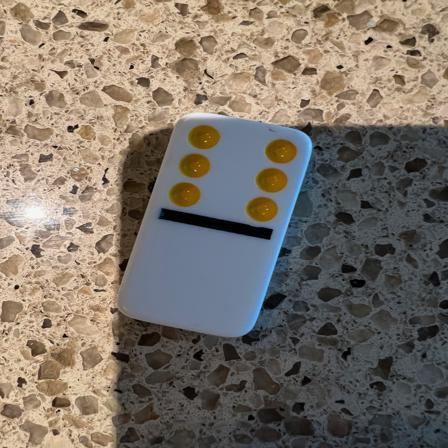

In [47]:
example['image']

#### Split Dataset into Training & Testing Datasets

In [26]:
train_test = data['train'].train_test_split(test_size=0.10)

train_ds = train_test['train']
test_ds = train_test['test']

#### Create Conversions Between String & Integer Values For Label Values

In [27]:
id2label = {0: "unlabeled", 1: "domino"}
label2id = {label: idx for idx, label in id2label.items()}

unqiue_label_values = list(id2label.values())

NUM_OF_LABELS = len(unqiue_label_values)

print(f"List of Unique Label Values: {unqiue_label_values}")
print(f"Number of Unique Label Values: {NUM_OF_LABELS}")
print(f"label2id dictionary values: {label2id}")
print(f"id2label dictionary values: {id2label}")

List of Unique Label Values: ['unlabeled', 'domino']
Number of Unique Label Values: 2
label2id dictionary values: {'unlabeled': 0, 'domino': 1}
id2label dictionary values: {0: 'unlabeled', 1: 'domino'}


#### Basic Values/Constants

In [28]:
MODEL_CKPT = "nvidia/mit-b0"
MODEL_NAME = f'{MODEL_CKPT.split("/")[-1]}-Image_segmentation_Dominoes_v2'

LR = 5e-4
NUM_OF_EPOCHS = 25

STRATEGY = "epoch"
REPORTS_TO = "tensorboard"

#### Define Image Processor

In [29]:
image_processor = AutoImageProcessor.from_pretrained(MODEL_CKPT, reduce_labels=False)

loading configuration file preprocessor_config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--nvidia--mit-b0/snapshots/ed0b85c75627eab6a3c6989627450cf95f115381/preprocessor_config.json
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/models/segformer/image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(
size should be a dictionary on of the following set of keys: ({'height', 'width'}, {'shortest_edge'}, {'longest_edge', 'shortest_edge'}), got 512. Converted to {'height': 512, 'width': 512}.
Image processor SegformerImageProcessor {
  "do_normalize": true,
  "do_reduce_labels": false,
  "do_rescale": true,
  "do_resize": true

#### Augment Data (to Prevent Model Overfitting)

In [30]:
jitter = ColorJitter(brightness=0.35, 
                     contrast=0.35, 
                     saturation=0.35, 
                     hue=0.20)

#### Define Function to Convert Any Greyscale Images to RGB Images

In [31]:
def prepare_greyscale_images(image):
    np_image = np.array(image)
    if np_image.ndim == 2:
        tiled_image = np.tile(np.expand_dims(np_image, -1), 3)
        return Image.fromarray(tiled_image)
    else:
        return Image.fromarray(np_image)

#### Use Above Functions to Create Functions to Transform Training Dataset

In [32]:
def train_transform(sample_batch):
    images = [prepare_greyscale_images(x) for x in sample_batch["image"]]
    labels = [x for x in sample_batch['annotation']]
    inputs = image_processor(images, labels)
    return inputs

#### Use Above Functions to Create Function to Transform Testing Dataset

In [33]:
def test_transform(sample_batch):
    images = [jitter(prepare_greyscale_images(x)) for x in sample_batch["image"]]
    labels = [x for x in sample_batch['annotation']]
    inputs = image_processor(images, labels)
    return inputs

#### Apply Transformation Functions on Respective Datasets

In [34]:
train_ds.set_transform(train_transform)
test_ds.set_transform(test_transform)

#### Define Compute Metrics Function

In [35]:
metric = evaluate.load("mean_iou")
    
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics = metric._compute(
            predictions=pred_labels,
            references=labels,
            num_labels=NUM_OF_LABELS,
            ignore_index=255,
            reduce_labels=False,
        )
        for key, value in metrics.items():
            if type(value) is np.ndarray:
                metrics[key] = value.tolist()
        return metrics

#### Define Function to Display Number of Trainable Parameters

In [36]:
def print_trainable_parameters(model):
    """
    This function prints the following values:
    - the number of parameters
    - the trainable parameters 
    - the percentage of total parameters 
        that are trainable.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"| Trainable parameters: {trainable_params} |")
    print(f"| All parameters: {all_param} |")
    print(f"| % Trainable: {100 * trainable_params / all_param:.2f}")    

#### Define Base Model

In [37]:
model = AutoModelForSemanticSegmentation.from_pretrained(
    MODEL_CKPT, 
    id2label=id2label, 
    label2id=label2id,
    ignore_mismatched_sizes=True)

print_trainable_parameters(model)

loading configuration file config.json from cache at /Users/briandunn/.cache/huggingface/hub/models--nvidia--mit-b0/snapshots/ed0b85c75627eab6a3c6989627450cf95f115381/config.json
Model config SegformerConfig {
  "_name_or_path": "nvidia/mit-b0",
  "architectures": [
    "SegformerForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 256,
  "depths": [
    2,
    2,
    2,
    2
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_sizes": [
    32,
    64,
    160,
    256
  ],
  "id2label": {
    "0": "unlabeled",
    "1": "domino"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "label2id": {
    "domino": 1,
    "unlabeled": 0
  },
  "layer_norm_eps": 1e-06,
  "mlp_ratios": [
    4,
    4,
    4,
    4
  ],
  "model_type": "segformer",
  "num_attention_heads": [
    1,
    2,
    5,
    8
  ],
  "num_chann

| Trainable parameters: 3714658 |
| All parameters: 3714658 |
| % Trainable: 100.00


#### Define LoRA Configuration

In [38]:
lora_config = LoraConfig(
    r=32, 
    lora_alpha=32,
    target_modules=['query', 'values'],
    lora_dropout=0.1,
    bias='lora_only',
    modules_to_save=['decode_head'],
)

#### Wrap Base Model With LoRA Configuration

In [39]:
lora_model = get_peft_model(model, 
                            lora_config)

print_trainable_parameters(lora_model)

| Trainable parameters: 857092 |
| All parameters: 4175460 |
| % Trainable: 20.53


#### Define Training Arguments

In [40]:
args = TrainingArguments(
    MODEL_NAME,
    learning_rate=LR,
    remove_unused_columns=False,
    num_train_epochs=NUM_OF_EPOCHS,
    auto_find_batch_size=True,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    label_names=['labels'],
    logging_first_step=True,
    logging_strategy="steps",
    logging_steps=24,
    load_best_model_at_end=True,
    report_to=REPORTS_TO,
    hub_private_repo=True,
    push_to_hub=True
)

PyTorch: setting up devices


#### Define Trainer

In [41]:
trainer = Trainer(
    lora_model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

/Users/briandunn/Desktop/Image Segmentation/Dominoes/Dominoes_v2/mit-b0-Image_segmentation_Dominoes_v2 is already a clone of https://huggingface.co/DunnBC22/mit-b0-Image_segmentation_Dominoes_v2. Make sure you pull the latest changes with `repo.git_pull()`.


#### Train Model

In [42]:
trainer.train()

/Users/briandunn/Desktop/python_venvs/text_sum/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 686
  Num Epochs = 25
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2150
  Number of trainable parameters = 857092


  0%|          | 0/2150 [00:00<?, ?it/s]

{'loss': 0.66, 'learning_rate': 0.0004997674418604651, 'epoch': 0.01}
{'loss': 0.2098, 'learning_rate': 0.0004944186046511627, 'epoch': 0.28}
{'loss': 0.0685, 'learning_rate': 0.0004888372093023256, 'epoch': 0.56}
{'loss': 0.0461, 'learning_rate': 0.0004832558139534884, 'epoch': 0.84}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9721967854031923, 0.8578619172251059]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9869082633464498, 0.9184139264010376]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-86
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.12327656149864197, 'eval_mean_iou': 0.9150293513141491, 'eval_mean_accuracy': 0.9526610948737437, 'eval_overall_accuracy': 0.9761918798669592, 'eval_per_category_iou': [0.9721967854031923, 0.8578619172251059], 'eval_per_category_accuracy': [0.9869082633464498, 0.9184139264010376], 'eval_runtime': 16.9947, 'eval_samples_per_second': 4.531, 'eval_steps_per_second': 0.588, 'epoch': 1.0}
{'loss': 0.0253, 'learning_rate': 0.00047767441860465114, 'epoch': 1.12}
{'loss': 0.0218, 'learning_rate': 0.0004720930232558139, 'epoch': 1.4}
{'loss': 0.0185, 'learning_rate': 0.00046651162790697676, 'epoch': 1.67}
{'loss': 0.0708, 'learning_rate': 0.00046093023255813954, 'epoch': 1.95}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9732821853093164, 0.8611008788165083]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9898473600751747, 0.9082362492748777]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-172
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.13664233684539795, 'eval_mean_iou': 0.9171915320629124, 'eval_mean_accuracy': 0.9490418046750262, 'eval_overall_accuracy': 0.9770787722104556, 'eval_per_category_iou': [0.9732821853093164, 0.8611008788165083], 'eval_per_category_accuracy': [0.9898473600751747, 0.9082362492748777], 'eval_runtime': 16.5905, 'eval_samples_per_second': 4.641, 'eval_steps_per_second': 0.603, 'epoch': 2.0}
{'loss': 0.0232, 'learning_rate': 0.0004553488372093023, 'epoch': 2.23}
{'loss': 0.0233, 'learning_rate': 0.00044976744186046516, 'epoch': 2.51}
{'loss': 0.048, 'learning_rate': 0.00044418604651162794, 'epoch': 2.79}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9740118174014271, 0.8658241844233872]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9888392553004053, 0.9179240730467295]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-258
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.12595057487487793, 'eval_mean_iou': 0.919918000912407, 'eval_mean_accuracy': 0.9533816641735674, 'eval_overall_accuracy': 0.9777441148634081, 'eval_per_category_iou': [0.9740118174014271, 0.8658241844233872], 'eval_per_category_accuracy': [0.9888392553004053, 0.9179240730467295], 'eval_runtime': 29.4271, 'eval_samples_per_second': 2.617, 'eval_steps_per_second': 0.34, 'epoch': 3.0}
{'loss': 0.0211, 'learning_rate': 0.00043860465116279067, 'epoch': 3.07}
{'loss': 0.0158, 'learning_rate': 0.0004330232558139535, 'epoch': 3.35}
{'loss': 0.0194, 'learning_rate': 0.0004274418604651163, 'epoch': 3.63}
{'loss': 0.0535, 'learning_rate': 0.00042186046511627907, 'epoch': 3.91}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.974142444792198, 0.8658711064023369]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9896291184589182, 0.9142864290038782]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-344
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1184200793504715, 'eval_mean_iou': 0.9200067755972674, 'eval_mean_accuracy': 0.9519577737313982, 'eval_overall_accuracy': 0.9778412657898742, 'eval_per_category_iou': [0.974142444792198, 0.8658711064023369], 'eval_per_category_accuracy': [0.9896291184589182, 0.9142864290038782], 'eval_runtime': 27.4965, 'eval_samples_per_second': 2.8, 'eval_steps_per_second': 0.364, 'epoch': 4.0}
{'loss': 0.036, 'learning_rate': 0.00041627906976744185, 'epoch': 4.19}
{'loss': 0.0207, 'learning_rate': 0.0004106976744186047, 'epoch': 4.47}
{'loss': 0.0185, 'learning_rate': 0.0004051162790697674, 'epoch': 4.74}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9737715695013129, 0.8627108292167807]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9910418746696423, 0.904378218719681]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-430
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.12956373393535614, 'eval_mean_iou': 0.9182411993590468, 'eval_mean_accuracy': 0.9477100466946617, 'eval_overall_accuracy': 0.9774827833299513, 'eval_per_category_iou': [0.9737715695013129, 0.8627108292167807], 'eval_per_category_accuracy': [0.9910418746696423, 0.904378218719681], 'eval_runtime': 16.6364, 'eval_samples_per_second': 4.628, 'eval_steps_per_second': 0.601, 'epoch': 5.0}
{'loss': 0.0221, 'learning_rate': 0.0003995348837209302, 'epoch': 5.02}
{'loss': 0.0188, 'learning_rate': 0.00039395348837209304, 'epoch': 5.3}
{'loss': 0.0253, 'learning_rate': 0.0003883720930232558, 'epoch': 5.58}
{'loss': 0.036, 'learning_rate': 0.0003827906976744186, 'epoch': 5.86}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9745002408443008, 0.8680673581922554]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9892677512186527, 0.9182967669045321]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-516
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.14100100100040436, 'eval_mean_iou': 0.9212837995182781, 'eval_mean_accuracy': 0.9537822590615924, 'eval_overall_accuracy': 0.9781638801871956, 'eval_per_category_iou': [0.9745002408443008, 0.8680673581922554], 'eval_per_category_accuracy': [0.9892677512186527, 0.9182967669045321], 'eval_runtime': 16.57, 'eval_samples_per_second': 4.647, 'eval_steps_per_second': 0.604, 'epoch': 6.0}
{'loss': 0.0148, 'learning_rate': 0.00037720930232558144, 'epoch': 6.14}
{'loss': 0.0118, 'learning_rate': 0.0003716279069767442, 'epoch': 6.42}
{'loss': 0.0256, 'learning_rate': 0.00036604651162790695, 'epoch': 6.7}
{'loss': 0.0376, 'learning_rate': 0.00036046511627906973, 'epoch': 6.98}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9741455743906073, 0.8669703237367214]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9883004639689904, 0.9216576612178001]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-602
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.14512722194194794, 'eval_mean_iou': 0.9205579490636644, 'eval_mean_accuracy': 0.9549790625933953, 'eval_overall_accuracy': 0.9778737650289164, 'eval_per_category_iou': [0.9741455743906073, 0.8669703237367214], 'eval_per_category_accuracy': [0.9883004639689904, 0.9216576612178001], 'eval_runtime': 16.4233, 'eval_samples_per_second': 4.688, 'eval_steps_per_second': 0.609, 'epoch': 7.0}
{'loss': 0.0241, 'learning_rate': 0.00035488372093023257, 'epoch': 7.26}
{'loss': 0.0235, 'learning_rate': 0.00034930232558139535, 'epoch': 7.53}
{'loss': 0.0186, 'learning_rate': 0.00034372093023255813, 'epoch': 7.81}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9733616852468584, 0.8616466350192237]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9897043519116697, 0.9094762400541087]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-688
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.13804595172405243, 'eval_mean_iou': 0.917504160133041, 'eval_mean_accuracy': 0.9495902959828892, 'eval_overall_accuracy': 0.9771521432059151, 'eval_per_category_iou': [0.9733616852468584, 0.8616466350192237], 'eval_per_category_accuracy': [0.9897043519116697, 0.9094762400541087], 'eval_runtime': 16.3694, 'eval_samples_per_second': 4.704, 'eval_steps_per_second': 0.611, 'epoch': 8.0}
{'loss': 0.0271, 'learning_rate': 0.00033813953488372097, 'epoch': 8.09}
{'loss': 0.0181, 'learning_rate': 0.00033255813953488375, 'epoch': 8.37}
{'loss': 0.0297, 'learning_rate': 0.0003269767441860465, 'epoch': 8.65}
{'loss': 0.0162, 'learning_rate': 0.0003213953488372093, 'epoch': 8.93}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9746840649852051, 0.8688930149000804]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.989455276913138, 0.9182917005479264]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-774
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1459001749753952, 'eval_mean_iou': 0.9217885399426428, 'eval_mean_accuracy': 0.9538734887305322, 'eval_overall_accuracy': 0.9783212736055449, 'eval_per_category_iou': [0.9746840649852051, 0.8688930149000804], 'eval_per_category_accuracy': [0.989455276913138, 0.9182917005479264], 'eval_runtime': 16.4631, 'eval_samples_per_second': 4.677, 'eval_steps_per_second': 0.607, 'epoch': 9.0}
{'loss': 0.0123, 'learning_rate': 0.0003158139534883721, 'epoch': 9.21}
{'loss': 0.032, 'learning_rate': 0.0003102325581395349, 'epoch': 9.49}
{'loss': 0.0169, 'learning_rate': 0.00030465116279069766, 'epoch': 9.77}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9739086600912814, 0.8642187978193332]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9901195747929759, 0.9102564589713776]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-860
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1467013657093048, 'eval_mean_iou': 0.9190637289553073, 'eval_mean_accuracy': 0.9501880168821768, 'eval_overall_accuracy': 0.9776244720855316, 'eval_per_category_iou': [0.9739086600912814, 0.8642187978193332], 'eval_per_category_accuracy': [0.9901195747929759, 0.9102564589713776], 'eval_runtime': 16.4671, 'eval_samples_per_second': 4.676, 'eval_steps_per_second': 0.607, 'epoch': 10.0}
{'loss': 0.0243, 'learning_rate': 0.0002990697674418605, 'epoch': 10.05}
{'loss': 0.0291, 'learning_rate': 0.0002934883720930233, 'epoch': 10.33}
{'loss': 0.0169, 'learning_rate': 0.000287906976744186, 'epoch': 10.6}
{'loss': 0.0102, 'learning_rate': 0.00028232558139534885, 'epoch': 10.88}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9737696499931041, 0.8644247331609153]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9889789745698009, 0.915789237032027]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-946
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.15493769943714142, 'eval_mean_iou': 0.9190971915770096, 'eval_mean_accuracy': 0.9523841058009139, 'eval_overall_accuracy': 0.9775279651988636, 'eval_per_category_iou': [0.9737696499931041, 0.8644247331609153], 'eval_per_category_accuracy': [0.9889789745698009, 0.915789237032027], 'eval_runtime': 16.4883, 'eval_samples_per_second': 4.67, 'eval_steps_per_second': 0.606, 'epoch': 11.0}
{'loss': 0.0379, 'learning_rate': 0.00027674418604651163, 'epoch': 11.16}
{'loss': 0.026, 'learning_rate': 0.0002711627906976744, 'epoch': 11.44}
{'loss': 0.0122, 'learning_rate': 0.00026558139534883725, 'epoch': 11.72}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


{'loss': 0.0204, 'learning_rate': 0.00026000000000000003, 'epoch': 12.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.974639596078376, 0.8682964916021273]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.989902977623774, 0.9155653673995151]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1032
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.15023675560951233, 'eval_mean_iou': 0.9214680438402516, 'eval_mean_accuracy': 0.9527341725116445, 'eval_overall_accuracy': 0.9782723761224127, 'eval_per_category_iou': [0.974639596078376, 0.8682964916021273], 'eval_per_category_accuracy': [0.989902977623774, 0.9155653673995151], 'eval_runtime': 16.4023, 'eval_samples_per_second': 4.694, 'eval_steps_per_second': 0.61, 'epoch': 12.0}
{'loss': 0.0108, 'learning_rate': 0.0002544186046511628, 'epoch': 12.28}
{'loss': 0.0319, 'learning_rate': 0.0002488372093023256, 'epoch': 12.56}
{'loss': 0.0268, 'learning_rate': 0.00024325581395348835, 'epoch': 12.84}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9740020531855834, 0.8647199376136]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.99011699066189, 0.9107963425971664]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1118
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1412886083126068, 'eval_mean_iou': 0.9193609953995917, 'eval_mean_accuracy': 0.9504566666295282, 'eval_overall_accuracy': 0.9777067605551187, 'eval_per_category_iou': [0.9740020531855834, 0.8647199376136], 'eval_per_category_accuracy': [0.99011699066189, 0.9107963425971664], 'eval_runtime': 16.4252, 'eval_samples_per_second': 4.688, 'eval_steps_per_second': 0.609, 'epoch': 13.0}
{'loss': 0.0181, 'learning_rate': 0.00023767441860465116, 'epoch': 13.12}
{'loss': 0.0213, 'learning_rate': 0.00023209302325581397, 'epoch': 13.4}
{'loss': 0.0184, 'learning_rate': 0.00022651162790697675, 'epoch': 13.67}
{'loss': 0.0166, 'learning_rate': 0.00022093023255813954, 'epoch': 13.95}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9731154475737929, 0.8614276032542578]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9884142831972749, 0.9152366875147241]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1204
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1583731472492218, 'eval_mean_iou': 0.9172715254140253, 'eval_mean_accuracy': 0.9518254853559995, 'eval_overall_accuracy': 0.9769651734983766, 'eval_per_category_iou': [0.9731154475737929, 0.8614276032542578], 'eval_per_category_accuracy': [0.9884142831972749, 0.9152366875147241], 'eval_runtime': 16.4301, 'eval_samples_per_second': 4.687, 'eval_steps_per_second': 0.609, 'epoch': 14.0}
{'loss': 0.0166, 'learning_rate': 0.00021534883720930232, 'epoch': 14.23}
{'loss': 0.0105, 'learning_rate': 0.00020976744186046513, 'epoch': 14.51}
{'loss': 0.0159, 'learning_rate': 0.0002041860465116279, 'epoch': 14.79}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9731832402253996, 0.8607442858381036]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9896456803899689, 0.9087960816798012]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1290
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1562587469816208, 'eval_mean_iou': 0.9169637630317515, 'eval_mean_accuracy': 0.949220881034885, 'eval_overall_accuracy': 0.9769962360332538, 'eval_per_category_iou': [0.9731832402253996, 0.8607442858381036], 'eval_per_category_accuracy': [0.9896456803899689, 0.9087960816798012], 'eval_runtime': 16.4516, 'eval_samples_per_second': 4.68, 'eval_steps_per_second': 0.608, 'epoch': 15.0}
{'loss': 0.0261, 'learning_rate': 0.0001986046511627907, 'epoch': 15.07}
{'loss': 0.0115, 'learning_rate': 0.0001930232558139535, 'epoch': 15.35}
{'loss': 0.0267, 'learning_rate': 0.00018744186046511628, 'epoch': 15.63}
{'loss': 0.0211, 'learning_rate': 0.00018186046511627907, 'epoch': 15.91}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9725201360275898, 0.8574847000491036]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.989323310037, 0.9068449010920532]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1376
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.14351056516170502, 'eval_mean_iou': 0.9150024180383467, 'eval_mean_accuracy': 0.9480841055645266, 'eval_overall_accuracy': 0.9764190277495941, 'eval_per_category_iou': [0.9725201360275898, 0.8574847000491036], 'eval_per_category_accuracy': [0.989323310037, 0.9068449010920532], 'eval_runtime': 16.4116, 'eval_samples_per_second': 4.692, 'eval_steps_per_second': 0.609, 'epoch': 16.0}
{'loss': 0.0133, 'learning_rate': 0.00017627906976744188, 'epoch': 16.19}
{'loss': 0.0228, 'learning_rate': 0.00017069767441860466, 'epoch': 16.47}
{'loss': 0.0128, 'learning_rate': 0.00016511627906976744, 'epoch': 16.74}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9745789801464504, 0.8677394402794754]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9901920479238856, 0.9136255861141298]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1462
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.14211878180503845, 'eval_mean_iou': 0.9211592102129629, 'eval_mean_accuracy': 0.9519088170190078, 'eval_overall_accuracy': 0.9782127281288048, 'eval_per_category_iou': [0.9745789801464504, 0.8677394402794754], 'eval_per_category_accuracy': [0.9901920479238856, 0.9136255861141298], 'eval_runtime': 16.475, 'eval_samples_per_second': 4.674, 'eval_steps_per_second': 0.607, 'epoch': 17.0}
{'loss': 0.021, 'learning_rate': 0.00015953488372093022, 'epoch': 17.02}
{'loss': 0.0208, 'learning_rate': 0.00015395348837209303, 'epoch': 17.3}
{'loss': 0.0119, 'learning_rate': 0.00014837209302325581, 'epoch': 17.58}
{'loss': 0.0167, 'learning_rate': 0.0001427906976744186, 'epoch': 17.86}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9746811993626879, 0.8686470009484697]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9897428202266988, 0.9166850322093621]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1548
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.15581434965133667, 'eval_mean_iou': 0.9216641001555788, 'eval_mean_accuracy': 0.9532139262180305, 'eval_overall_accuracy': 0.9783124552144633, 'eval_per_category_iou': [0.9746811993626879, 0.8686470009484697], 'eval_per_category_accuracy': [0.9897428202266988, 0.9166850322093621], 'eval_runtime': 16.3576, 'eval_samples_per_second': 4.707, 'eval_steps_per_second': 0.611, 'epoch': 18.0}
{'loss': 0.0155, 'learning_rate': 0.0001372093023255814, 'epoch': 18.14}
{'loss': 0.018, 'learning_rate': 0.0001316279069767442, 'epoch': 18.42}
{'loss': 0.0097, 'learning_rate': 0.00012604651162790697, 'epoch': 18.7}
{'loss': 0.0201, 'learning_rate': 0.00012046511627906977, 'epoch': 18.98}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9727184720007118, 0.8584339325695252]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9894484642039114, 0.9072695251050635]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1634
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.16230051219463348, 'eval_mean_iou': 0.9155762022851185, 'eval_mean_accuracy': 0.9483589946544875, 'eval_overall_accuracy': 0.9765910359172078, 'eval_per_category_iou': [0.9727184720007118, 0.8584339325695252], 'eval_per_category_accuracy': [0.9894484642039114, 0.9072695251050635], 'eval_runtime': 17.2315, 'eval_samples_per_second': 4.469, 'eval_steps_per_second': 0.58, 'epoch': 19.0}
{'loss': 0.0214, 'learning_rate': 0.00011488372093023255, 'epoch': 19.26}
{'loss': 0.0182, 'learning_rate': 0.00010930232558139536, 'epoch': 19.53}
{'loss': 0.0133, 'learning_rate': 0.00010372093023255814, 'epoch': 19.81}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9738320500157303, 0.8640203613069115]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9898665061373113, 0.9112263496140702]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1720
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.15733253955841064, 'eval_mean_iou': 0.9189262056613209, 'eval_mean_accuracy': 0.9505464278756908, 'eval_overall_accuracy': 0.9775627433479607, 'eval_per_category_iou': [0.9738320500157303, 0.8640203613069115], 'eval_per_category_accuracy': [0.9898665061373113, 0.9112263496140702], 'eval_runtime': 16.4506, 'eval_samples_per_second': 4.681, 'eval_steps_per_second': 0.608, 'epoch': 20.0}
{'loss': 0.0124, 'learning_rate': 9.813953488372094e-05, 'epoch': 20.09}
{'loss': 0.0175, 'learning_rate': 9.255813953488372e-05, 'epoch': 20.37}
{'loss': 0.0215, 'learning_rate': 8.69767441860465e-05, 'epoch': 20.65}
{'loss': 0.012, 'learning_rate': 8.139534883720931e-05, 'epoch': 20.93}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9731344243001482, 0.8597866189796295]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9904592118400188, 0.9040137576913626]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1806
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.16311487555503845, 'eval_mean_iou': 0.9164605216398889, 'eval_mean_accuracy': 0.9472364847656907, 'eval_overall_accuracy': 0.9769342595880682, 'eval_per_category_iou': [0.9731344243001482, 0.8597866189796295], 'eval_per_category_accuracy': [0.9904592118400188, 0.9040137576913626], 'eval_runtime': 16.3499, 'eval_samples_per_second': 4.71, 'eval_steps_per_second': 0.612, 'epoch': 21.0}
{'loss': 0.0195, 'learning_rate': 7.58139534883721e-05, 'epoch': 21.21}
{'loss': 0.0096, 'learning_rate': 7.023255813953489e-05, 'epoch': 21.49}
{'loss': 0.0148, 'learning_rate': 6.465116279069767e-05, 'epoch': 21.77}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9735162429121835, 0.8627239955489192]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9894034768309156, 0.9120129014770962]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1892
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1628579944372177, 'eval_mean_iou': 0.9181201192305514, 'eval_mean_accuracy': 0.9507081891540059, 'eval_overall_accuracy': 0.9772952191241375, 'eval_per_category_iou': [0.9735162429121835, 0.8627239955489192], 'eval_per_category_accuracy': [0.9894034768309156, 0.9120129014770962], 'eval_runtime': 16.9646, 'eval_samples_per_second': 4.539, 'eval_steps_per_second': 0.589, 'epoch': 22.0}
{'loss': 0.0145, 'learning_rate': 5.906976744186047e-05, 'epoch': 22.05}
{'loss': 0.0176, 'learning_rate': 5.348837209302326e-05, 'epoch': 22.33}
{'loss': 0.0102, 'learning_rate': 4.7906976744186046e-05, 'epoch': 22.6}
{'loss': 0.0137, 'learning_rate': 4.232558139534884e-05, 'epoch': 22.88}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9719681843338751, 0.8552607882028388]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9885083690609032, 0.908250815050119]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-1978
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.1701258420944214, 'eval_mean_iou': 0.913614486268357, 'eval_mean_accuracy': 0.9483795920555111, 'eval_overall_accuracy': 0.9759515539392248, 'eval_per_category_iou': [0.9719681843338751, 0.8552607882028388], 'eval_per_category_accuracy': [0.9885083690609032, 0.908250815050119], 'eval_runtime': 17.2345, 'eval_samples_per_second': 4.468, 'eval_steps_per_second': 0.58, 'epoch': 23.0}
{'loss': 0.0121, 'learning_rate': 3.6744186046511624e-05, 'epoch': 23.16}
{'loss': 0.011, 'learning_rate': 3.116279069767442e-05, 'epoch': 23.44}
{'loss': 0.0135, 'learning_rate': 2.558139534883721e-05, 'epoch': 23.72}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


{'loss': 0.0142, 'learning_rate': 2e-05, 'epoch': 24.0}


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9723134197764093, 0.8568918401744342]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9887405884771245, 0.9089100747034281]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-2064
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.16463343799114227, 'eval_mean_iou': 0.9146026299754217, 'eval_mean_accuracy': 0.9488253315902764, 'eval_overall_accuracy': 0.9762505865716314, 'eval_per_category_iou': [0.9723134197764093, 0.8568918401744342], 'eval_per_category_accuracy': [0.9887405884771245, 0.9089100747034281], 'eval_runtime': 16.5904, 'eval_samples_per_second': 4.641, 'eval_steps_per_second': 0.603, 'epoch': 24.0}
{'loss': 0.0185, 'learning_rate': 1.441860465116279e-05, 'epoch': 24.28}
{'loss': 0.0145, 'learning_rate': 8.837209302325582e-06, 'epoch': 24.56}
{'loss': 0.0156, 'learning_rate': 3.2558139534883724e-06, 'epoch': 24.84}


***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.9723929259786395, 0.856345354289624]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9898487696012216, 0.9032139066422469]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2/checkpoint-2150
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 0.16153134405612946, 'eval_mean_iou': 0.9143691401341317, 'eval_mean_accuracy': 0.9465313381217342, 'eval_overall_accuracy': 0.97629418311181, 'eval_per_category_iou': [0.9723929259786395, 0.856345354289624], 'eval_per_category_accuracy': [0.9898487696012216, 0.9032139066422469], 'eval_runtime': 16.3649, 'eval_samples_per_second': 4.705, 'eval_steps_per_second': 0.611, 'epoch': 25.0}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from mit-b0-Image_segmentation_Dominoes_v2/checkpoint-344 (score: 0.1184200793504715).


{'train_runtime': 11473.4494, 'train_samples_per_second': 1.495, 'train_steps_per_second': 0.187, 'train_loss': 0.02368642721065255, 'epoch': 25.0}


TrainOutput(global_step=2150, training_loss=0.02368642721065255, metrics={'train_runtime': 11473.4494, 'train_samples_per_second': 1.495, 'train_steps_per_second': 0.187, 'train_loss': 0.02368642721065255, 'epoch': 25.0})

In [43]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 77
  Batch size = 8


  0%|          | 0/10 [00:00<?, ?it/s]

Trainer is attempting to log a value of "[0.974110559111975, 0.8655745252092782]" of type <class 'list'> for key "eval/per_category_iou" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "[0.9897833441005461, 0.913253525550903]" of type <class 'list'> for key "eval/per_category_accuracy" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 0.11491713672876358,
 'eval_mean_iou': 0.9198425421606267,
 'eval_mean_accuracy': 0.9515184348257246,
 'eval_overall_accuracy': 0.9778097573812906,
 'eval_per_category_iou': [0.974110559111975, 0.8655745252092782],
 'eval_per_category_accuracy': [0.9897833441005461, 0.913253525550903],
 'eval_runtime': 16.8487,
 'eval_samples_per_second': 4.57,
 'eval_steps_per_second': 0.594,
 'epoch': 25.0}

#### Save Model

In [44]:
lora_model.save_pretrained(f'DunnBC22/{MODEL_NAME}')

#### Push Model to Hub

In [45]:
trainer.push_to_hub("All DUNN!!!")

Saving model checkpoint to mit-b0-Image_segmentation_Dominoes_v2
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


Upload file runs/Jul26_16-13-57_Brians-Mac-mini/events.out.tfevents.1690406040.Brians-Mac-mini.18899.2:   0%| …

Upload file runs/Jul26_16-13-57_Brians-Mac-mini/events.out.tfevents.1690417530.Brians-Mac-mini.18899.4:   0%| …

To https://huggingface.co/DunnBC22/mit-b0-Image_segmentation_Dominoes_v2
   b1757f7..9a10fec  main -> main

To https://huggingface.co/DunnBC22/mit-b0-Image_segmentation_Dominoes_v2
   9a10fec..3773bdd  main -> main



'https://huggingface.co/DunnBC22/mit-b0-Image_segmentation_Dominoes_v2/commit/9a10fec84746c059cd0e59364255a9e4b5e4fc42'

### Notes & Other Takeaways From This Project

****
- I am surprised at both how well the results are of this project and how quickly this project converged on the optimal weights. 

****

### Citations

- Model Checkpoint (nvidia/mit-b0)
    > @article{DBLP:journals/corr/abs-2105-15203, author = {Enze Xie and Wenhai Wang and Zhiding Yu and Anima Anandkumar and Jose M. Alvarez and Ping Luo}, title = {SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers}, journal = {CoRR}, volume = {abs/2105.15203}, year = {2021}, url = {https://arxiv.org/abs/2105.15203}, eprinttype = {arXiv}, eprint = {2105.15203}, timestamp = {Wed, 02 Jun 2021 11:46:42 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2105-15203.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Metrics (mean_iou)
    > @software{MMSegmentation_Contributors_OpenMMLab_Semantic_Segmentation_2020, author = {{MMSegmentation Contributors}}, license = {Apache-2.0}, month = {7}, title = {{OpenMMLab Semantic Segmentation Toolbox and Benchmark}}, url = {https://github.com/open-mmlab/mmsegmentation}, year = {2020}}